In [1]:
!pip install datasets gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset
from collections import Counter
import gensim.downloader as api
import numpy as np
import os
import json
import torch
import torch.nn as nn
import torch.functional as F
import json
from tqdm.auto import tqdm
import sys


# Loading dataset and data processing

In [3]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [4]:
word2vec_model = api.load('glove-wiki-gigaword-100')
embeddings = word2vec_model.vectors
w2v_vocab = word2vec_model.key_to_index

[==================================================] 100.0% 128.1/128.1MB downloaded


In [5]:
len(w2v_vocab)

400000

In [6]:
w2v_vocab['<UNK>'] = 400000
w2v_vocab['<PAD>'] = 400001

In [7]:
avg_vec = np.mean(embeddings, axis=0)

In [8]:
avg_vec

array([ 0.05209883, -0.09711445, -0.1380765 ,  0.11075345, -0.02722748,
       -0.00326409,  0.03176443, -0.05076874,  0.15321693, -0.02367382,
       -0.0078552 ,  0.08436131, -0.08042031, -0.08836847, -0.01713637,
        0.07352565, -0.16472325,  0.05473585,  0.15367231, -0.05284015,
       -0.16474274, -0.00894895, -0.13604094, -0.03889371, -0.09204532,
        0.02874651,  0.02445944,  0.19419461, -0.03297978,  0.00509352,
        0.0146906 , -0.1554301 ,  0.03542742, -0.02936257,  0.01372886,
       -0.0606757 ,  0.02025392, -0.14560148,  0.05823914,  0.01729455,
        0.16282158,  0.18634756, -0.06337869,  0.1306742 , -0.11122588,
        0.0272168 ,  0.03868013,  0.15675613,  0.01344932,  0.1942456 ,
       -0.01218801,  0.03659216, -0.08235365, -0.24420363,  0.07523726,
        0.46423653,  0.06318451,  0.0508127 , -0.38147202, -0.20739552,
        0.03489431, -0.18234783,  0.09021272, -0.02504168, -0.22256528,
        0.03382994, -0.13379364, -0.14375682, -0.11264054, -0.03

In [9]:
embeddings[-1]

array([ 0.28365  , -0.6263   , -0.44351  ,  0.2177   , -0.087421 ,
       -0.17062  ,  0.29266  , -0.024899 ,  0.26414  , -0.17023  ,
        0.25817  ,  0.097484 , -0.33103  , -0.43859  ,  0.0095799,
        0.095624 , -0.17777  ,  0.38886  ,  0.27151  ,  0.14742  ,
       -0.43973  , -0.26588  , -0.024271 ,  0.27186  , -0.36761  ,
       -0.24827  , -0.20815  ,  0.22128  , -0.044409 ,  0.021373 ,
        0.24594  ,  0.26143  ,  0.29303  ,  0.13281  ,  0.082232 ,
       -0.12869  ,  0.1622   , -0.22567  , -0.060348 ,  0.28703  ,
        0.11381  ,  0.34839  ,  0.3419   ,  0.36996  , -0.13592  ,
        0.0062694,  0.080317 ,  0.0036251,  0.43093  ,  0.01882  ,
        0.31008  ,  0.16722  ,  0.074112 , -0.37745  ,  0.47363  ,
        0.41284  ,  0.24471  ,  0.075965 , -0.51725  , -0.49481  ,
        0.526    , -0.074645 ,  0.41434  , -0.1956   , -0.16544  ,
       -0.045649 , -0.40153  , -0.13136  , -0.4672   ,  0.18825  ,
        0.2612   ,  0.16854  ,  0.22615  ,  0.62992  , -0.1288

In [10]:
embeddings = np.append(embeddings, [avg_vec], axis=0)
embeddings = np.append(embeddings, [np.zeros_like(embeddings[-1])], axis=0)

## Tokenizing

1. We ignore the words
2. We map them to `UNK`, available in word2vec vocab

In [11]:
def tokenize(vocab, text):
    """Tokenize a given text using NLTK, returning the corresponding in our pretrained embeddings"""
    tokens = word_tokenize(text.lower())  # Tokenize the text into words
    token_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]  # Get token IDs
    return {"tokens": tokens, "ids": token_ids}

In [12]:
nltk.download('punkt')

class NLTKTokenizer:
    def __init__(self, config=None):
        self.vocab = {'<UNK>': 400000, '<PAD>': 400001}
        self.config = config or {}
        self.pad_id = None  # Store pad_id for future use

    @classmethod
    def from_pretrained(cls, vocab):
        """Load a tokenizer with a pre-built vocabulary from a saved file."""
        tokenizer = cls()
        tokenizer.vocab = vocab
        tokenizer.pad_id = vocab.get("<PAD>", 1)  # Ensure pad_id is set
        return tokenizer

    def build_vocab(self):
        """Build vocabulary from the given dataset."""
        from collections import Counter
        from datasets import load_dataset

        dataset = load_dataset(self.config["dataset"])
        train_dataset = dataset['train']
        vocab = Counter(self.vocab)
        for item in train_dataset:
            tokens = word_tokenize(item['text'].lower())
            vocab.update(tokens)
        self.vocab = {word: idx for idx, (word, _) in enumerate(vocab.items(), 1)}  # Index starts at 1
        #print(self.vocab)

    def tokenize(self, text):
        """Tokenize a given text using NLTK."""
        tokens = word_tokenize(text.lower())  # Tokenize the text into words
        token_ids = [self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]  # Get token IDs
        # token_ids = [self.vocab.get(token, np.zeros_like(self.vocab['UNK'])) for token in tokens]  # Get token IDs

        return {"tokens": tokens, "ids": token_ids}

    def save(self, folder_path):
        """Save the vocabulary to a file."""
        os.makedirs(folder_path, exist_ok=True)
        with open(os.path.join(folder_path, "vocab.json"), "w") as f:
            json.dump(self.vocab, f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
tokenizer = NLTKTokenizer.from_pretrained(w2v_vocab)

## Dataloader

In [14]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [15]:
class ClassificationDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item["text"]
        label = item["label"]
        ids = self.tokenizer.tokenize(text)["ids"]
        length = len(ids)
        ids = torch.tensor(ids)
        return ids, length, label

In [16]:
def get_dataloaders(
    tokenizer,
    dataset,
    training_bs,
    val_bs,
):
    train_dataset = ClassificationDataset(dataset["train"], tokenizer)
    validation_dataset = ClassificationDataset(dataset["validation"], tokenizer)
    test_dataset = ClassificationDataset(dataset["test"], tokenizer)
    # partial function to be used in DataLoader
    def padding_fn(batch):
        # pad sequences in the same batch to be the same shape
        (xx, lengths, yy) = zip(*batch)
        xx_pad = pad_sequence(xx, batch_first=True, padding_value=tokenizer.pad_id)
        return xx_pad, torch.tensor(lengths), torch.tensor(yy)
    train_loader = DataLoader(train_dataset, batch_size=training_bs, shuffle=True, collate_fn=padding_fn)
    val_loader   = DataLoader(validation_dataset, batch_size=val_bs, shuffle=True, collate_fn=padding_fn)
    test_loader  = DataLoader(test_dataset, batch_size=val_bs, shuffle=True, collate_fn=padding_fn)

    return train_loader, val_loader, test_loader

In [17]:
train_loader, val_loader, test_loader = get_dataloaders(
    tokenizer=tokenizer,
    dataset=dataset,
    training_bs=32,
    val_bs=32,
)

# Initializing the model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
class RNNLayer(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output, direction=1, device=device):
        super(RNNLayer, self).__init__()
        self.dim_input = dim_input
        self.dim_hidden = dim_hidden

        self.i2h = nn.Linear(dim_input + dim_hidden, dim_hidden).to(device)
        self.i2o = nn.Linear(dim_input + dim_hidden, dim_output).to(device)
        self.direction = direction

    def forward(self, input, hidden):
        outputs = []
        if self.direction == 1:
            for i in range(input.size()[1]):
                combined = torch.cat((input[:, i, :], hidden), dim=1)
                hidden = self.i2h(combined)
                output_cell = self.i2o(combined)
                outputs.append(output_cell)
        else:
            for i in range(input.size()[1]-1, -1, -1):
                combined = torch.cat((input[:, i, :], hidden), dim=1)
                hidden = self.i2h(combined)
                output_cell = self.i2o(combined)
                outputs.append(output_cell)
        return torch.stack(outputs, dim=1) # (batch_size, seq_len, dim_output)

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.dim_hidden)

class RNN(nn.Module):
    def __init__(self, vocab_size, dim_input, dim_hidden, dim_output, pretrained_embeddings=None, freeze_embeddings=True, device=device):
        super(RNN, self).__init__()

        if pretrained_embeddings is not None:
            print("Loading pretrained word embeddings")
            self.token_embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embeddings, dtype=torch.float),
                freeze=freeze_embeddings
            ).to(device)
        else:
            self.token_embedding = nn.Embedding(vocab_size, dim_input).to(device)

        self.dim_input = dim_input
        self.dim_hidden = dim_hidden
        self.dim_output = dim_output

        self.rnn_layer = RNNLayer(dim_input, dim_hidden, dim_output, device)
        self.softmax = nn.LogSoftmax(dim=-1).to(device)
        self.sigmoid = nn.Sigmoid().to(device)

    def initialize(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input):
        hidden = self.rnn_layer.init_hidden(input.size()[0]).to(device)
        embedded = self.token_embedding(input)
        outputs = self.rnn_layer(embedded, hidden)
        if self.dim_output > 2:
            outputs = self.softmax(outputs)
        else:
            outputs = self.softmax(outputs)
        return outputs

    def init_hidden(self, batch_size):
        return torch.Variable(torch.zeros((batch_size, self.dim_hidden)))

In [39]:
len(w2v_vocab)

400002

In [76]:
vocab_size=len(w2v_vocab)
dim_input = embeddings[0].shape[0]
dim_hidden = 256

In [77]:
dim_input

100

# Training loop

Use the pretrained word embeddings from Part 1 as inputs; do not update them during training (they are “frozen”).

Design a simple recurrent neural network (RNN), taking the input word embeddings, and predicting a sentiment label for each sentence. To do that, you need to consider how to aggregate the word representations to represent a sentence.

Use the validation set to gauge the performance of the model for each epoch during training. You are required to use accuracy  as the performance metric during validation and evaluation.

Use the mini-batch strategy during training.  You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You should use the validation set to determine the optimal configuration.) Train the model until the accuracy  score on the validation set is not increasing for a few epochs.

Evaluate your trained model on the test dataset, observing the accuracy score.

In [107]:
model = RNN(vocab_size=len(w2v_vocab),
            dim_input=dim_input,
            dim_hidden=dim_hidden,
            dim_output=2,
            pretrained_embeddings=embeddings,
            freeze_embeddings=True,
            device=device)

Loading pretrained word embeddings


In [108]:
learning_rate = 1e-4
num_epochs = 100
metric_log_interval = 1
num_stopping_rounds = 10
loss_fn = nn.BCELoss()
training_bs = 32

In [109]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

In [110]:
model.train()
train_loss = 0
data_iter = iter(train_loader)

In [111]:
class EarlyStopper:
    def __init__(self, patience=50, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [112]:
early_stopper = EarlyStopper(patience=num_stopping_rounds,
                             min_delta=0)
train_loss = []
val_loss = []
metrics = []
for step_id in tqdm(range(num_epochs)):

    epoch_loss = []
    for i, (input, length, label) in tqdm(enumerate(train_loader)):

        input, length, label = input.to(device), length.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(input)
        output = output[range(input.size()[0]), length - 1]
        one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float).to(device)
        loss = loss_fn(output, one_hot_label)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item() / training_bs)

        output_label = torch.argmax(output, axis=1)

    train_loss.append(sum(epoch_loss) / len(epoch_loss))

    epoch_loss = []
    epoch_acc = []
    with torch.no_grad():
        for i, (input, length, label) in enumerate(val_loader):
            input, length, label = input.to(device), length.to(device), label.to(device)

            output = model(input)
            output = output[range(input.size()[0]), length - 1]
            one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)

            loss = loss_fn(output, one_hot_label)
            epoch_loss.append(loss.item() / training_bs)

            output_label = torch.argmax(output, axis=1)
            epoch_acc.append((output_label == label).sum() / len(label))

    epoch_loss_ = sum(epoch_loss) / len(epoch_loss)
    val_loss.append(epoch_loss_)
    metrics.append(sum(epoch_acc) / len(epoch_acc))
    print(
            f"""Step {step_id + 1}:
                Train Loss: {train_loss[-1]},
                Val_loss: {val_loss[-1]},
                Accuracy:{metrics[-1]}"""
    )
    if early_stopper.early_stop(epoch_loss_):
        print('Early Stopping model training')
        break

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

<ipython-input-112-e65c2413c703>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float).to(device)
<ipython-input-112-e65c2413c703>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)


Step 1:
                Train Loss: 0.021623127518242663,
                Val_loss: 0.021607246688183618,
                Accuracy:0.5248161554336548


0it [00:00, ?it/s]

Step 2:
                Train Loss: 0.02150078767331575,
                Val_loss: 0.021434895420337424,
                Accuracy:0.5220588445663452


0it [00:00, ?it/s]

Step 3:
                Train Loss: 0.021224742085578736,
                Val_loss: 0.02114179719458608,
                Accuracy:0.5398897528648376


0it [00:00, ?it/s]

Step 4:
                Train Loss: 0.021146691624033317,
                Val_loss: 0.021103323492057183,
                Accuracy:0.5562500357627869


0it [00:00, ?it/s]

Step 5:
                Train Loss: 0.02104851882555958,
                Val_loss: 0.021107486010912585,
                Accuracy:0.5470588207244873


0it [00:00, ?it/s]

Step 6:
                Train Loss: 0.020847348782342026,
                Val_loss: 0.02080943961353863,
                Accuracy:0.559374988079071


0it [00:00, ?it/s]

Step 7:
                Train Loss: 0.0207766191301386,
                Val_loss: 0.020710653625428677,
                Accuracy:0.5764706134796143


0it [00:00, ?it/s]

Step 8:
                Train Loss: 0.020671492093678717,
                Val_loss: 0.02082547309863217,
                Accuracy:0.5628676414489746


0it [00:00, ?it/s]

Step 9:
                Train Loss: 0.020832637848144167,
                Val_loss: 0.020602649516042543,
                Accuracy:0.5573529601097107


0it [00:00, ?it/s]

Step 10:
                Train Loss: 0.020664391041583335,
                Val_loss: 0.020986618967178988,
                Accuracy:0.5626838207244873


0it [00:00, ?it/s]

Step 11:
                Train Loss: 0.020641212752751645,
                Val_loss: 0.0211609952042208,
                Accuracy:0.5430147051811218


0it [00:00, ?it/s]

Step 12:
                Train Loss: 0.020703316453411783,
                Val_loss: 0.0215843440964818,
                Accuracy:0.5694852471351624


0it [00:00, ?it/s]

Step 13:
                Train Loss: 0.020593039231019072,
                Val_loss: 0.020695409354041603,
                Accuracy:0.5691176652908325


0it [00:00, ?it/s]

Step 14:
                Train Loss: 0.02057243278773313,
                Val_loss: 0.02066850760842071,
                Accuracy:0.5636029243469238


0it [00:00, ?it/s]

Step 15:
                Train Loss: 0.020486482603942858,
                Val_loss: 0.020800377351834494,
                Accuracy:0.5613970756530762


0it [00:00, ?it/s]

Step 16:
                Train Loss: 0.02058594800838817,
                Val_loss: 0.020599669612505856,
                Accuracy:0.5814337730407715


0it [00:00, ?it/s]

Step 17:
                Train Loss: 0.020529110082303095,
                Val_loss: 0.020699057454133734,
                Accuracy:0.5729779601097107


0it [00:00, ?it/s]

Step 18:
                Train Loss: 0.020538321957829293,
                Val_loss: 0.020667371723581764,
                Accuracy:0.5731617212295532


0it [00:00, ?it/s]

Step 19:
                Train Loss: 0.020560054052690888,
                Val_loss: 0.02050669485812678,
                Accuracy:0.5580882430076599


0it [00:00, ?it/s]

Step 20:
                Train Loss: 0.020671740502174876,
                Val_loss: 0.020796211984227684,
                Accuracy:0.5711397528648376


0it [00:00, ?it/s]

Step 21:
                Train Loss: 0.02055159867619084,
                Val_loss: 0.020969611044754,
                Accuracy:0.5533088445663452


0it [00:00, ?it/s]

Step 22:
                Train Loss: 0.020505494504385675,
                Val_loss: 0.02070578483535963,
                Accuracy:0.576286792755127


0it [00:00, ?it/s]

Step 23:
                Train Loss: 0.0205291620340575,
                Val_loss: 0.020458228502641704,
                Accuracy:0.5957720875740051


0it [00:00, ?it/s]

Step 24:
                Train Loss: 0.020491696140739354,
                Val_loss: 0.02089037888628595,
                Accuracy:0.5759190917015076


0it [00:00, ?it/s]

Step 25:
                Train Loss: 0.020407274309615517,
                Val_loss: 0.021212523912682253,
                Accuracy:0.5615808963775635


0it [00:00, ?it/s]

Step 26:
                Train Loss: 0.02049820718777537,
                Val_loss: 0.02094288740087958,
                Accuracy:0.578125


0it [00:00, ?it/s]

Step 27:
                Train Loss: 0.020439705131261535,
                Val_loss: 0.0204694635946961,
                Accuracy:0.5689338445663452


0it [00:00, ?it/s]

Step 28:
                Train Loss: 0.020509885847289463,
                Val_loss: 0.020766687305534586,
                Accuracy:0.5610294342041016


0it [00:00, ?it/s]

Step 29:
                Train Loss: 0.020545114431711618,
                Val_loss: 0.020587280173512065,
                Accuracy:0.580514669418335


0it [00:00, ?it/s]

Step 30:
                Train Loss: 0.020419330653570565,
                Val_loss: 0.020856761537930545,
                Accuracy:0.5773897171020508


0it [00:00, ?it/s]

Step 31:
                Train Loss: 0.020376576110720634,
                Val_loss: 0.020665572353583926,
                Accuracy:0.5783088207244873


0it [00:00, ?it/s]

Step 32:
                Train Loss: 0.02034855028439997,
                Val_loss: 0.02047872872037046,
                Accuracy:0.588051438331604


0it [00:00, ?it/s]

Step 33:
                Train Loss: 0.020326706040162273,
                Val_loss: 0.020630421610001254,
                Accuracy:0.5718750357627869
Early Stopping model training


In [113]:
import matplotlib.pyplot as plt

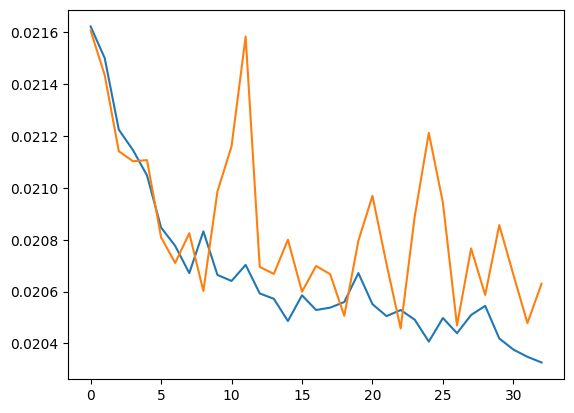

In [114]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

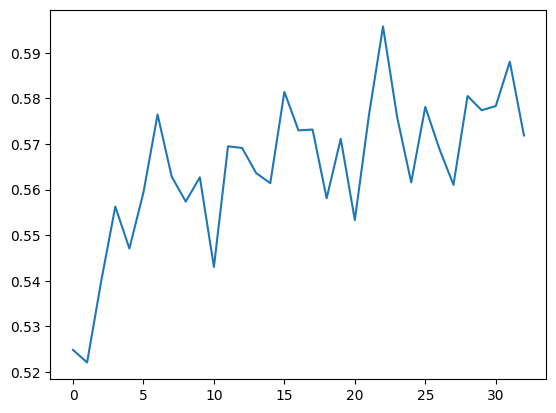

In [115]:
plt.plot(metrics)

# Evaluation

In [128]:
test_acc = []

for i, (input, length, label) in enumerate(test_loader):
    input, length, label = input.to(device), length.to(device), label.to(device)
    output = model(input)
    output = output[range(input.size()[0]), length - 1]
    one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)

    output_label = torch.argmax(output, axis=1)
    print(output_label.shape)
    test_acc.append((output_label == label).sum())

<ipython-input-128-af1aeb5e6922>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot_label = torch.tensor(nn.functional.one_hot(label), dtype=torch.float32).to(device)


torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([10])


In [134]:
sum(test_acc) / len(test_dataset)

tensor(0.5760)